* some codes are borrowed from Yabebal Fantaye and https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf.

In [2]:
## Importing the libraries:
import os, sys

import cachetools.func

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

## WHO Health Observatory API wrapper

Below is a python code that you can use to get health related data for any country in the world from World Health Organisation (WHO). To learn more about the description of the data available there check their [Global Health Observatory](https://www.who.int/data/gho) page. In particular, you can refer to the [indicators](https://www.who.int/data/gho/data/indicators) and [Data API](https://www.who.int/data/gho/info/gho-odata-api) pages.

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def agegrp_func(x):
    if 'AGELT1' in x:
        y = '0-1'
    elif 'AGE85' in x:
        y = '85+'
    else:
        y=x.replace('AGE','')

    return y

def agegrp_mid(x):
    if 'AGELT1' in x:
        y = -3
    elif 'AGE85' in x:
        y = 87
    else:
        try:
            y=int(np.mean([int(i) for i in x.replace('AGE','').split('-')]))
        except:
            y = int(x.replace('AGE','').split('-')[0])
    return y  

class whoapi():

    def __init__(self, dim='GHO',**kwargs):
    #
        self.url = f"http://apps.who.int/gho/athena/api/{dim}"
        self.verbose = kwargs.get('verbose',0)
    @staticmethod
    def age_sex_stem(df):    
        if 'AGEGROUP' in df.columns:
            df['MidAge'] = df['AGEGROUP'].map(agegrp_mid)
            df['AGEGROUP'] = df['AGEGROUP'].map(agegrp_func)       
            df = df.sort_values('MidAge').reset_index().drop(columns=['index'])

        if 'SEX' in df.columns:
            df['SEX'] = df['SEX'].map(lambda x:{'MLE':'Male',
                                                  'FMLE':'Female',
                                                  'BTSX':'Both'}.get(x,x))
        return df    
    def get_ids(self,s):
        df = self.dfid

        name = s
        if isinstance(s,str):
            name = [s]    

        dflist = [] 
        for d in name:
            dflist.append(df[df['id'].map(lambda x : d in x)])

        #try:
        df = pd.concat(dflist)
        #except:
        #  df = pd.DataFrame()

        return df
    
    def get_gho_data(self, id, fdict=None, 
                   url=None,verbose=None):
        #
        verbose = self.verbose if verbose is None else verbose
        #
        ids = id
        if isinstance(id,list):
            ids = ','.join(id)

        if url is None:
            url = f"{self.url}/{ids}.csv"

        if verbose>1:
            print('API url:',url)

        if not fdict is None:
            url += '?filter=' + ";".join([f"{k}:{v}" for k, v in fdict.items()])

        df = pd.read_csv(url)
        df = df.dropna(axis=1, how='all')
        try:
            df = df.drop(columns=['Comments'])
            df = df.drop(columns=['Comments'])
        except:
            #print('not dropping Comments')
            pass

        return df

    def country_data(self,ids,countries=['ETH'],year=2016):    

        if isinstance(countries,str):
            countries = [countries]

        dflist = []
        verbose=self.verbose
        for c in countries:
            print(f'processing country={c}')
            df = self.get_gho_data(ids,fdict={'COUNTRY':c,'YEAR':year},verbose=verbose)
            print(df.shape)
            verbose += 2
            dflist.append(df)

        df = pd.concat(dflist)
        print('all_df.shape',df.shape)
        return df

    def death_rates(self,**kwargs):

        name = 'LIFE_0000000029'
        try:
            return self.age_sex_stem(self.country_data(name,**kwargs))
        except:
            return self.country_data(name,**kwargs)

    def dying_prob(self,**kwargs):
        name = 'LIFE_0000000030'
        df = self.country_data(name,**kwargs)
        try:
            return self.age_sex_stem(df)
        except:
            raise
            return df  
    
    def prop_dying_ncd_3070(self,**kwargs):
        name = 'NCDMORT3070'
        df = self.country_data(name,**kwargs)
        try:
            return self.age_sex_stem(df)
        except:
            return df

processing country=KEN
(38, 9)
processing country=ITA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (76, 9)
dying prob df.shape (76, 10)


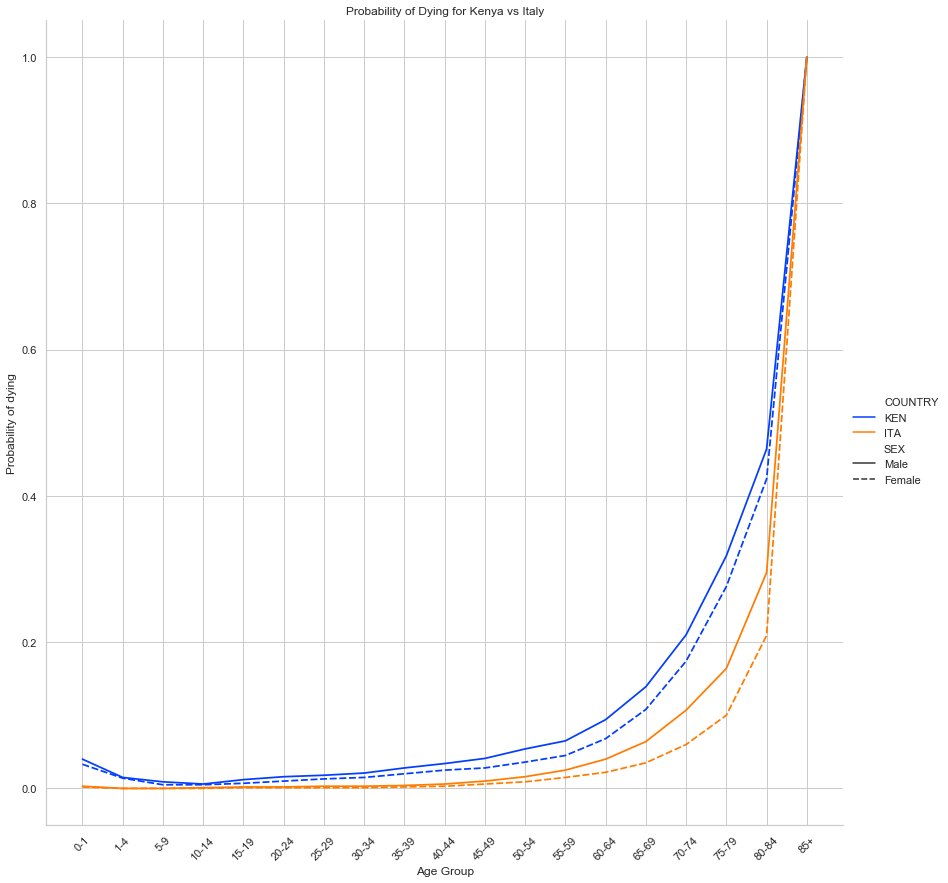

In [4]:
#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries my country Italy
df_pd = hapi.dying_prob(countries=["KEN","ITA"])

#plot data
print('dying prob df.shape',df_pd.shape)
xtickslabel = df_pd['AGEGROUP'].unique()
xticks = df_pd['MidAge'].unique()

#plotting the probability of dying
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='AGEGROUP',y='Display Value',data=df_pd,hue='COUNTRY', kind='line', ci=None,  height= 12,sort=False, lw= 1.75,style='SEX')
g.set(title = 'Probability of Dying for Kenya vs Italy',xlabel='Age Group',ylabel='Probability of dying')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.show()

processing country=KEN
(38, 9)
processing country=USA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (76, 9)
dying prob df.shape (76, 10)


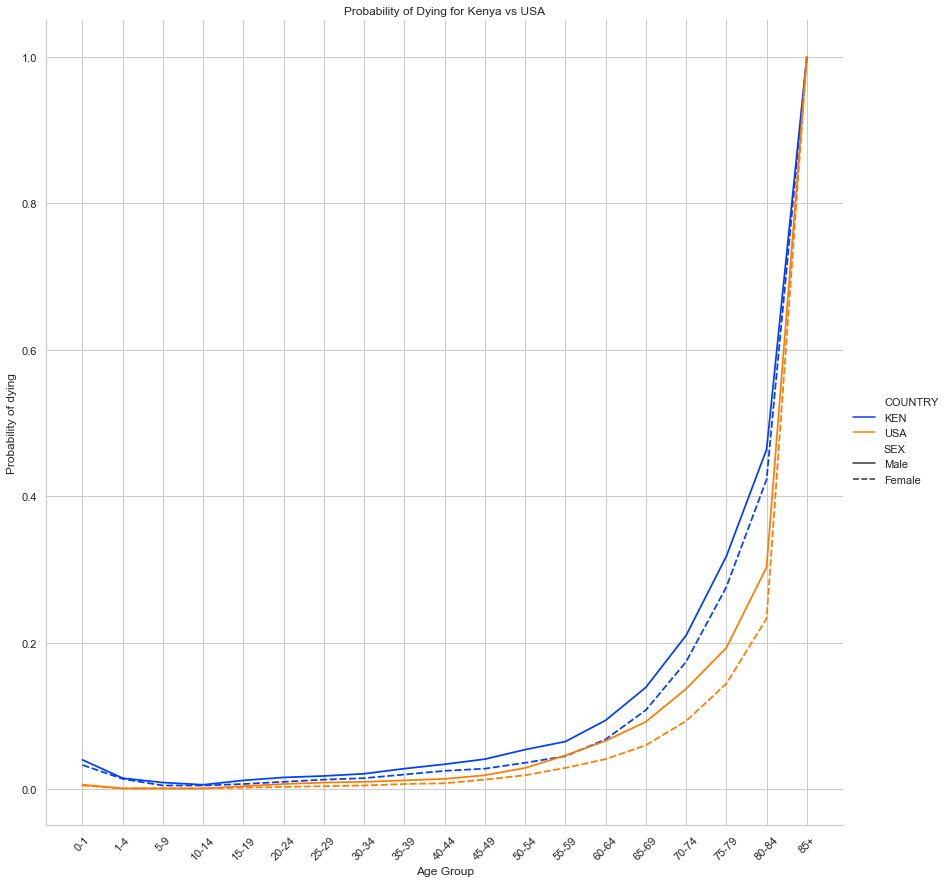

In [5]:

#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries my country Italy
df_pd = hapi.dying_prob(countries=["KEN","USA"])

#plot data
print('dying prob df.shape',df_pd.shape)
xtickslabel = df_pd['AGEGROUP'].unique()
xticks = df_pd['MidAge'].unique()

#plotting the probability of dying
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='AGEGROUP',y='Display Value',data=df_pd,hue='COUNTRY', kind='line', ci=None,  height= 12,sort=False, lw= 1.75,style='SEX')
g.set(title = 'Probability of Dying for Kenya vs USA',xlabel='Age Group',ylabel='Probability of dying')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.show()

processing country=KEN
(38, 9)
processing country=BRA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (76, 9)
dying prob df.shape (76, 10)


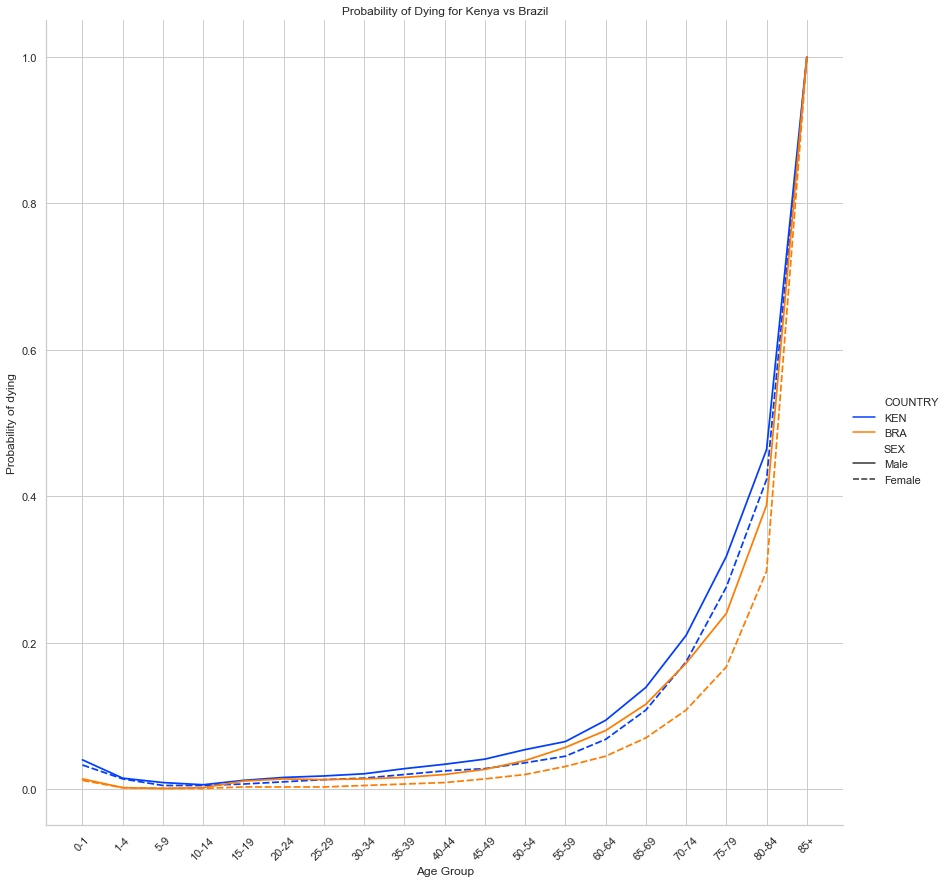

In [6]:

#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries my country Italy
df_pd = hapi.dying_prob(countries=["KEN","BRA"])

#plot data
print('dying prob df.shape',df_pd.shape)
xtickslabel = df_pd['AGEGROUP'].unique()
xticks = df_pd['MidAge'].unique()

#plotting the probability of dying
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='AGEGROUP',y='Display Value',data=df_pd,hue='COUNTRY', kind='line', ci=None,  height= 12,sort=False, lw= 1.75,style='SEX')
g.set(title = 'Probability of Dying for Kenya vs Brazil',xlabel='Age Group',ylabel='Probability of dying')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.show()

processing country=KEN
(38, 9)
processing country=IND
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (76, 9)
dying prob df.shape (76, 10)


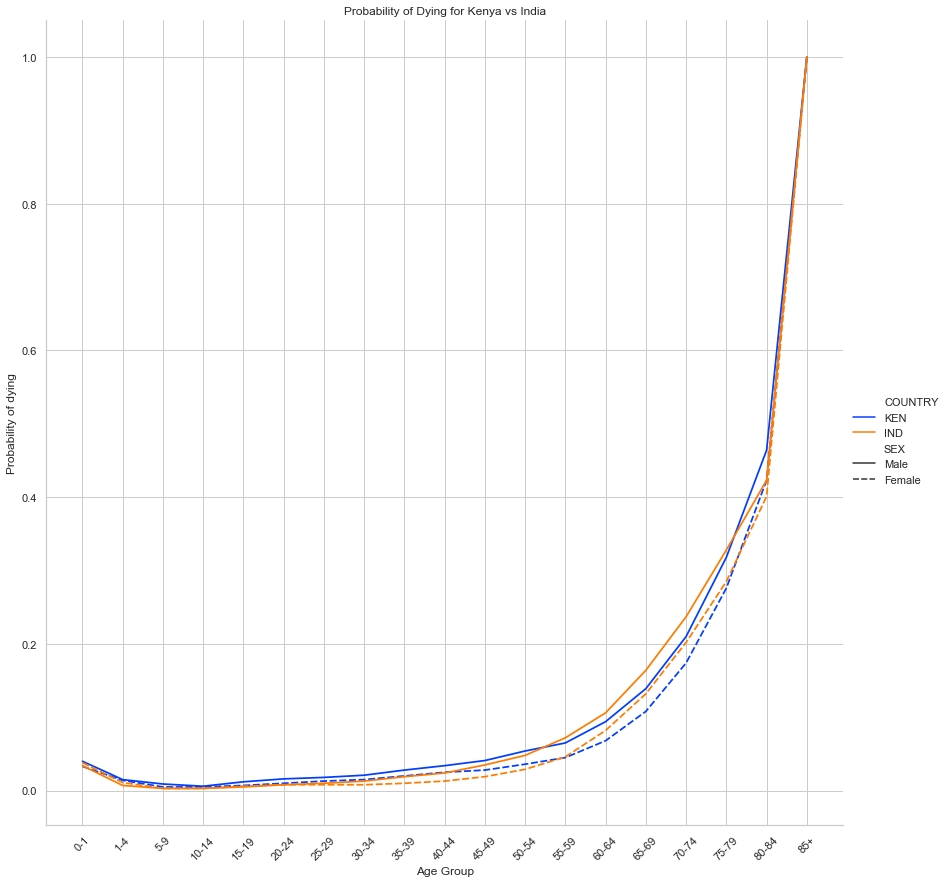

In [7]:
'''
Here is a starter code to give you a hint
'''
#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries my country Italy
df_pd = hapi.dying_prob(countries=["KEN","IND"])

#plot data
print('dying prob df.shape',df_pd.shape)
xtickslabel = df_pd['AGEGROUP'].unique()
xticks = df_pd['MidAge'].unique()

#plotting the probability of dying
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='AGEGROUP',y='Display Value',data=df_pd,hue='COUNTRY', kind='line', ci=None,  height= 12,sort=False, lw= 1.75,style='SEX')
g.set(title = 'Probability of Dying for Kenya vs India',xlabel='Age Group',ylabel='Probability of dying')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.show()

processing country=KEN
(38, 9)
processing country=ITA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
processing country=USA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
processing country=BRA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
processing country=IND
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (190, 9)
dying prob df.shape (190, 10)


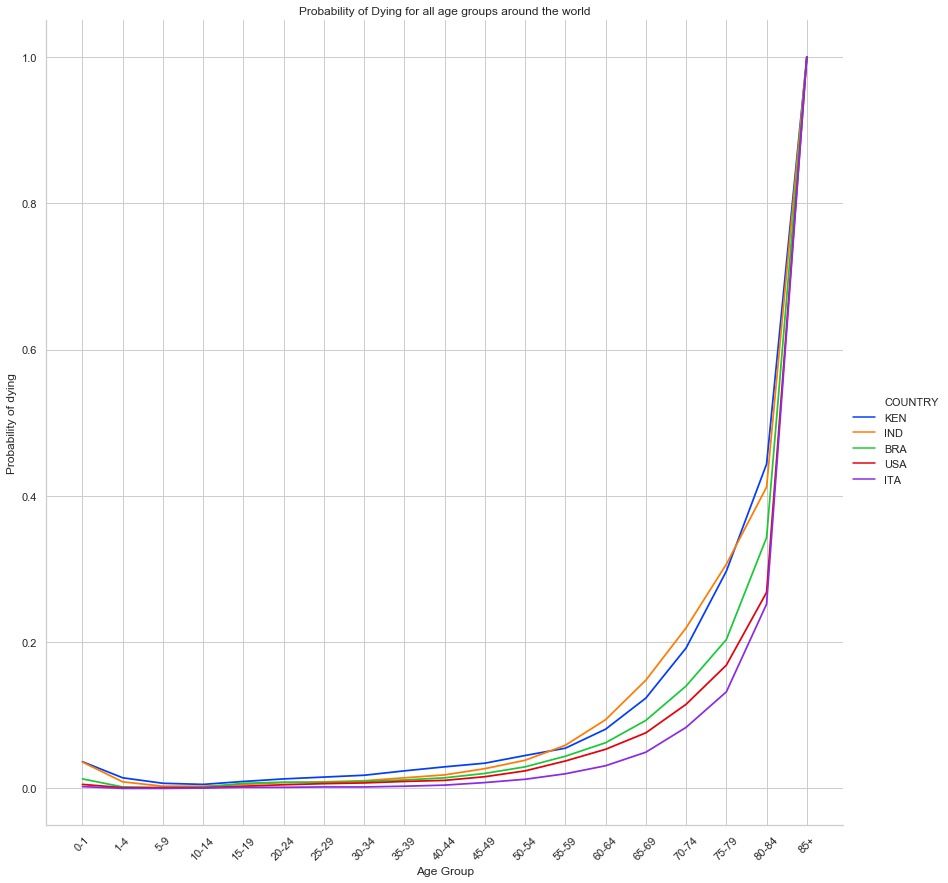

In [8]:

#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries my country against all top countries in all continents
df_pd = hapi.dying_prob(countries=["KEN","ITA",'USA','BRA','IND'])

#plot data
print('dying prob df.shape',df_pd.shape)
xtickslabel = df_pd['AGEGROUP'].unique()
xticks = df_pd['MidAge'].unique()

#plotting the probability of dying
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='AGEGROUP',y='Display Value',data=df_pd,hue='COUNTRY', kind='line', ci=None,  height= 12,sort=False, lw= 1.75)
g.set(title = 'Probability of Dying for all age groups around the world',xlabel='Age Group',ylabel='Probability of dying')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.show()

In [9]:
plt.clf()

<Figure size 432x288 with 0 Axes>

processing country=KEN
(38, 9)
processing country=RWA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
processing country=TZA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
processing country=UGA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
processing country=BDI
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
processing country=SSD
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (228, 9)
dying prob df.shape (228, 10)


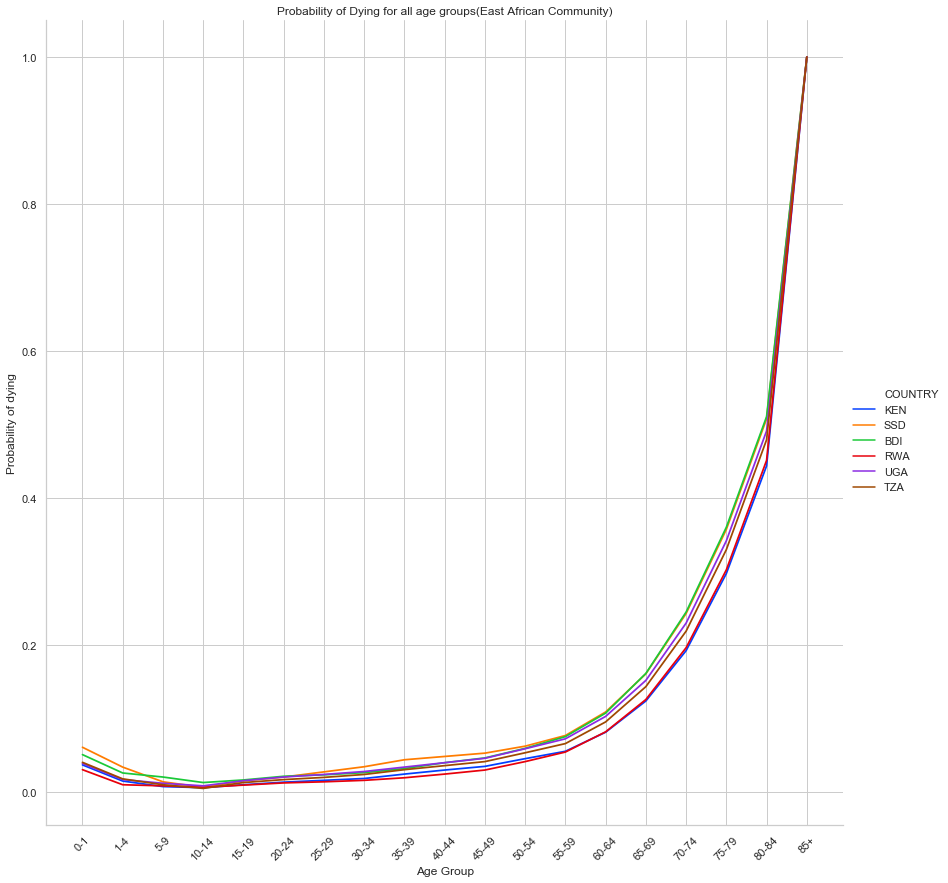

In [10]:

#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries
df_pd = hapi.dying_prob(countries=["KEN","RWA",'TZA','UGA','BDI','SSD'])

#plot data
print('dying prob df.shape',df_pd.shape)
xtickslabel = df_pd['AGEGROUP'].unique()
xticks = df_pd['MidAge'].unique()

#plotting the probability of dying
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='AGEGROUP',y='Display Value',data=df_pd,hue='COUNTRY', kind='line', ci=None,  height= 12,sort=False, lw= 1.75)
g.set(title = 'Probability of Dying for all age groups(East African Community)',xlabel='Age Group',ylabel='Probability of dying')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.show()

In [11]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [12]:
death_data_i = hapi.death_rates(countries=["KEN","ITA",'USA','BRA','IND'])
death_data_e = hapi.death_rates(countries=["KEN","RWA",'TZA','UGA','BDI','SSD'])

processing country=KEN
(38, 9)
processing country=ITA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
processing country=USA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
processing country=BRA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
processing country=IND
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
all_df.shape (190, 9)
processing country=KEN
(38, 9)
processing country=RWA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
processing country=TZA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
processing country=UGA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
processing country=BDI
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
processing country=SSD
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
all_df.shape (228, 9)


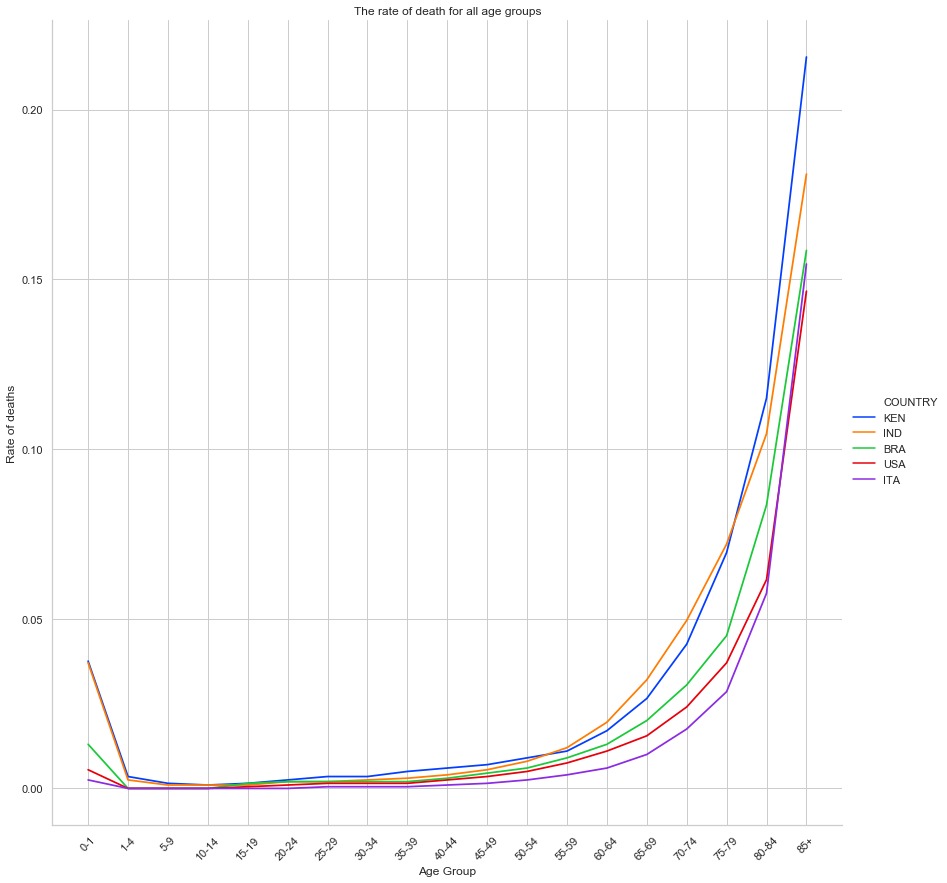

In [13]:
#plotting the probability of dying my country against all top countries in all continents
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='AGEGROUP',y='Display Value',data=death_data_i,hue='COUNTRY', kind='line', ci=None,  height= 12,sort=False,lw= 1.75)
g.set(title = 'The rate of death for all age groups',xlabel='Age Group',ylabel='Rate of deaths')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.show()

In [14]:
plt.clf()

<Figure size 432x288 with 0 Axes>

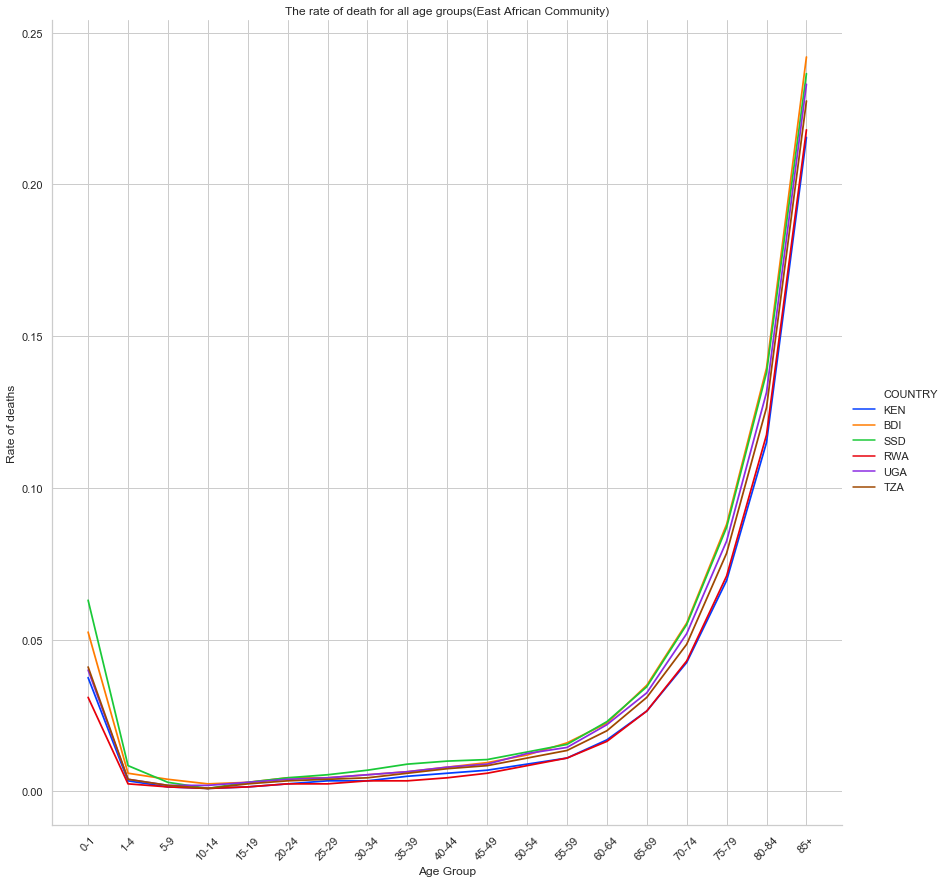

In [15]:
#plotting the probability of dying
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='AGEGROUP',y='Display Value',data=death_data_e,hue='COUNTRY', kind='line', ci=None,  height= 12,sort=False,lw= 1.75)
g.set(title = 'The rate of death for all age groups(East African Community)',xlabel='Age Group',ylabel='Rate of deaths')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.show()

In [16]:
plt.clf()

<Figure size 432x288 with 0 Axes>

processing country=KEN
(3, 8)
processing country=ITA
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
processing country=USA
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
processing country=BRA
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
processing country=IND
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
all_df.shape (15, 8)
dying prob df.shape (15, 8)


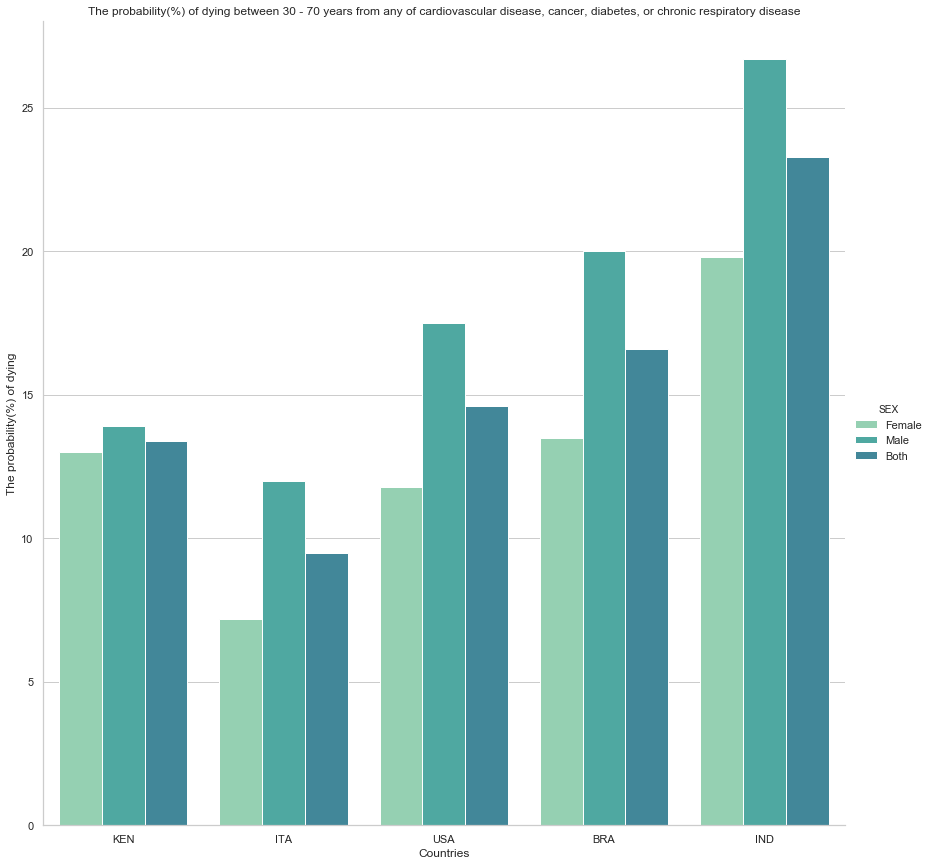

In [17]:
df_all_ncd_i = hapi.prop_dying_ncd_3070(countries=["KEN","ITA",'USA','BRA','IND'])
print('dying prob df.shape',df_all_ncd_i.shape)
sns.set_style("whitegrid")
sns.set_palette('bright')

#my country against all top countries in all continents
g = sns.catplot(x='COUNTRY',y='Display Value',data=df_all_ncd_i,hue='SEX', kind='bar', height= 12,palette=sns.color_palette("mako_r", 6))
g.set(title = 'The probability(%) of dying between 30 - 70 years from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease',xlabel='Countries',ylabel='The probability(%) of dying')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.show()

processing country=KEN
(3, 8)
processing country=RWA
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
processing country=TZA
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
processing country=UGA
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
processing country=BDI
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
processing country=SSD
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
all_df.shape (18, 8)
dying prob df.shape (18, 8)


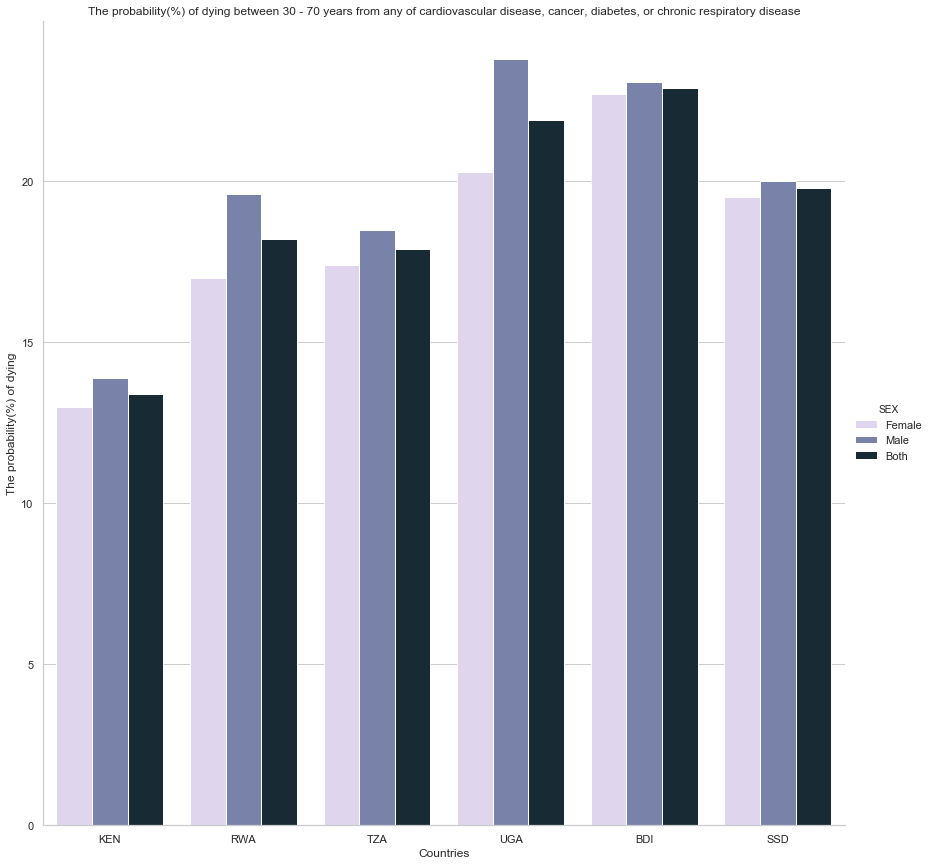

In [18]:
df_all_ncd_e = hapi.prop_dying_ncd_3070(countries=["KEN","RWA",'TZA','UGA','BDI','SSD'])
print('dying prob df.shape',df_all_ncd_e.shape)
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.catplot(x='COUNTRY',y='Display Value',data=df_all_ncd_e,hue='SEX', kind='bar', height= 12,palette="ch:2.5,.25")
g.set(title = 'The probability(%) of dying between 30 - 70 years from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease',xlabel='Countries',ylabel='The probability(%) of dying')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.show()

# COVID19 Data Analysis 

Below is a python class that you could use to download latest COVID19 data from John Hopkins Server for any contry in the world.

In [19]:
#-----      
#-----
def fix_region_name(df, pairs = [["Mainland China", "China"]]):
    # fix region names
    for p in pairs:
        df['Country/Region'] = df['Country/Region'].str.replace(p[0],p[1])

    return df

#-----
def merge_df_data(df1,df2):
    return pd.merge(df1, df2,how='left' ,on=['Province/State','Country/Region'])

#-----
def str_add_func(*args):      
    out = []
    for x in args:
        if isinstance(x,str):
            out.append(x)

    return '_'.join(out)


class covid_data():
    
    def __init__(self,**kwargs):

    #
        nrow = kwargs.get('nrow',None)
        self.confirmed, self.dead, self.recovered = self.get_csseg_data(nrow=nrow)

    @staticmethod
    def create_ts(df):
        ts=df
        columns = ts['region']
        ts=ts.drop(['Province/State', 
                    'Country/Region',
                    'Lat', 
                    'Long',
                    'Population'], 
                   axis=1).set_index('region').T    

        ts.columns = columns 
        ts=ts.fillna(0)
        #
        ts.index.name = 'Date'
        return ts

    def search_agg(self, name,col='Country/Region',ts=True):
    
        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():
            df_list= []
            for n in name:
                df = v[v[col]==n].set_index(col).filter(regex='/20')
                df_list.append(df.sum(axis=0))

                
            df = pd.concat(df_list,axis=1, sort=False)
            df.columns = name
            out[k] = df

          # if ts:                
          #   out[k] = self.create_ts(df)
          # else:
          #   out[k] = df.T

        return out

    def search(self, name,col='Country/Region',ts=True):
    
        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():
            if ts:                
                out[k] = self.create_ts(v[v[col].map(lambda x: x in name)])
            else:
                out[k] = v[v[col] in name].T

        return out

    @cachetools.func.ttl_cache(maxsize=128, ttl=24 * 60)
    def get_csseg_data(self, nrow=None):
    
        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master'
        path = f'{url}/csse_covid_19_data/csse_covid_19_time_series' 

        # 

        url = f'{path}/time_series_covid19_confirmed_global.csv'
        confirmed = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_deaths_global.csv'
        dead = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_recovered_global.csv'
        recovered = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        print(confirmed.head())
        #
        return confirmed, dead, recovered


In [20]:
cd = covid_data()
cd.confirmed.head(20)
countries = ['South Sudan','Tanzania','Uganda','Kenya','Burundi','Rwanda']
mm = cd.search_agg(countries)

  Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/26/20  6/27/20  6/28/20  6/29/20  \
0        0        0        0  ...    30451    30616    30967    31238   
1        0        0        0  ...     2269     2330     2402     2466   
2        0        0        0  ...    12685    12968    13273    13571   
3        0        0        0  ...      855      855      855      855   
4        0        0        0  ...      212      259      267      276   

   6/30/20  7/1/20  7/2/20  7/3/20  7/4/20  7/5/20  
0    31517   31836   32022 

In [21]:
for ix, ctype in enumerate(['confirmed']):
    dfc = mm[ctype].stack().reset_index()
    #print(df.head())
    dfc = dfc.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        dfc['date'] = pd.to_datetime(dfc['date'])
        dfall = dfc
    else:
        dfall[ctype] = dfc[ctype]

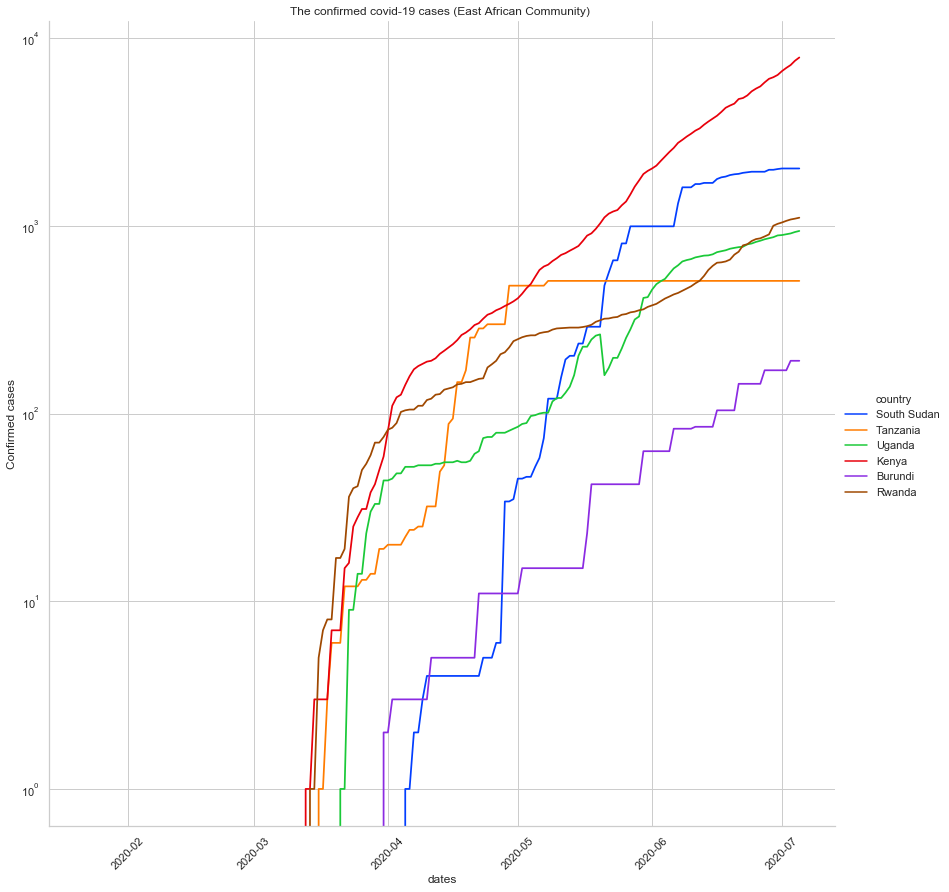

In [22]:
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='date',y='confirmed',data=dfc,hue='country', kind='line', ci=None,  height= 12,sort=False,lw= 1.75)
g.set(title = 'The confirmed covid-19 cases (East African Community) ',xlabel='dates',ylabel='Confirmed cases')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.yscale('log')
plt.savefig("The confirmed covid-19 cases (East African Community).png")
plt.show()

In [23]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [24]:
for ix, ctype in enumerate(['dead']):
    dfd = mm[ctype].stack().reset_index()
    #print(df.head())
    dfd = dfd.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        dfd['date'] = pd.to_datetime(dfd['date'])
        dfall = dfd
    else:
        dfall[ctype] = dfd[ctype]

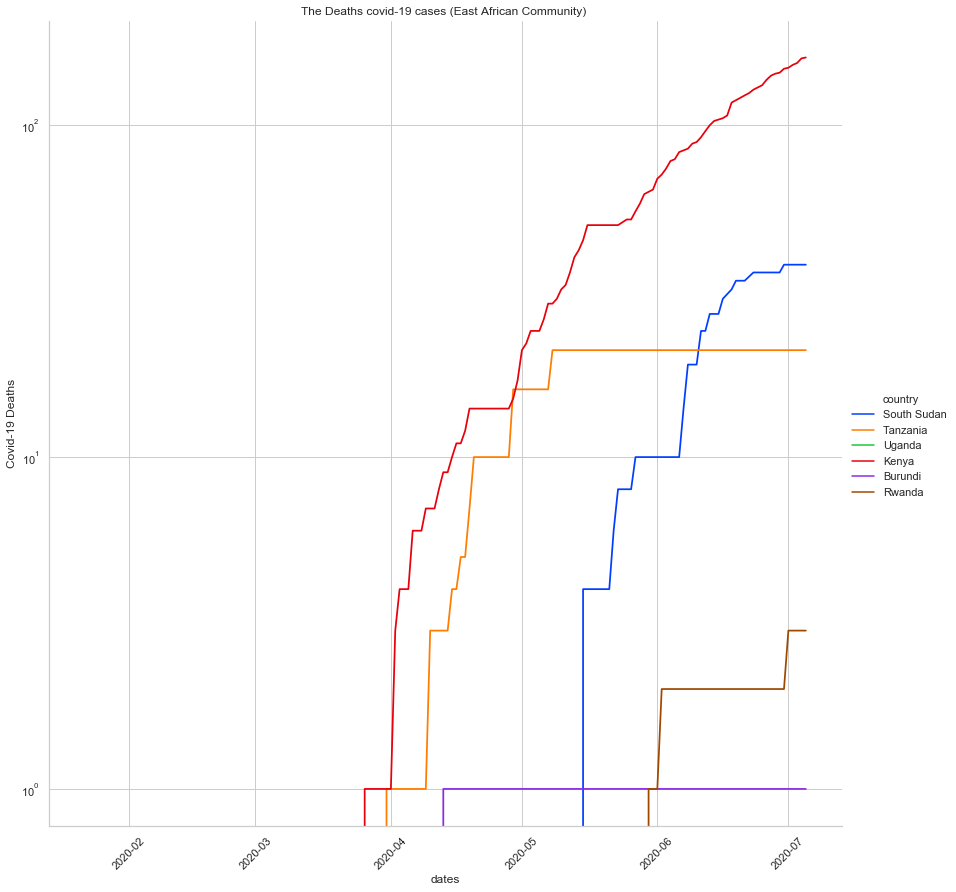

In [25]:
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='date',y='dead',data=dfd,hue='country', kind='line', ci=None,  height= 12,sort=False,lw= 1.75)
g.set(title = 'The Deaths covid-19 cases (East African Community) ',xlabel='dates',ylabel='Covid-19 Deaths')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.yscale('log')
plt.savefig("The Deaths covid-19 cases (East African Community).png")
plt.show()

In [26]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [27]:
for ix, ctype in enumerate(['recovered']):
    dfr = mm[ctype].stack().reset_index()
    #print(df.head())
    dfr = dfr.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        dfr['date'] = pd.to_datetime(dfr['date'])
        dfall = dfr
    else:
        dfall[ctype] = dfr[ctype]

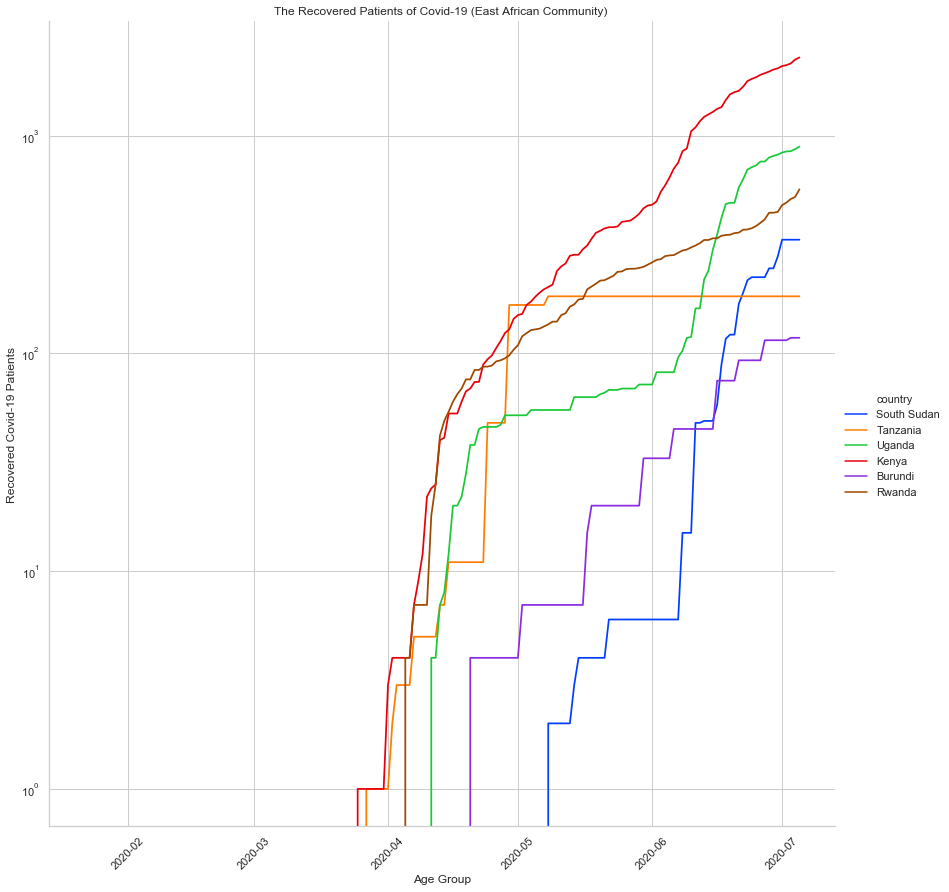

In [28]:
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='date',y='recovered',data=dfr,hue='country', kind='line', ci=None,  height= 12,sort=False,lw= 1.75)
g.set(title = 'The Recovered Patients of Covid-19 (East African Community) ',xlabel='Age Group',ylabel='Recovered Covid-19 Patients ')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.yscale('log')
plt.savefig("The Recovered Patients of Covid-19 (East African Community).png")
plt.show()

In [29]:
plt.clf()

<Figure size 432x288 with 0 Axes>

## Have a theory that the deaths in corona countries is related to the consumption of GMO foods in the country


In [30]:
cd = covid_data()
cd.confirmed.head(20)
countries3 = ['South Africa','Egypt','Australia','Italy','China','Venezuela','Kenya','Madagascar','Algeria']
mm3 = cd.search_agg(countries3)

  Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/26/20  6/27/20  6/28/20  6/29/20  \
0        0        0        0  ...    30451    30616    30967    31238   
1        0        0        0  ...     2269     2330     2402     2466   
2        0        0        0  ...    12685    12968    13273    13571   
3        0        0        0  ...      855      855      855      855   
4        0        0        0  ...      212      259      267      276   

   6/30/20  7/1/20  7/2/20  7/3/20  7/4/20  7/5/20  
0    31517   31836   32022 

In [31]:
for ix, ctype in enumerate(['confirmed']):
    dfc3 = mm3[ctype].stack().reset_index()
    #print(df.head())
    dfc3 = dfc3.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        dfc3['date'] = pd.to_datetime(dfc3['date'])
        dfall = dfc3
    else:
        dfall[ctype] = dfc3[ctype]
        
for ix, ctype in enumerate(['dead']):
    dfd3 = mm3[ctype].stack().reset_index()
    #print(df.head())
    dfd3 = dfd3.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        dfd3['date'] = pd.to_datetime(dfd3['date'])
        dfall = dfd3
    else:
        dfall[ctype] = dfd3[ctype]

In [32]:
#-----      
#-----
def fix_region_name2(df, pairs = [["Mainland China", "China"]]):
    # fix region names
    for p in pairs:
        df['Country_Region'] = df['Country_Region'].str.replace(p[0],p[1])

    return df

#-----
def merge_df_data2(df1,df2):
    return pd.merge(df1, df2,how='left' ,on=['Province_State','Country_Region'])

#-----
def str_add_func2(*args):      
    out = []
    for x in args:
        if isinstance(x,str):
            out.append(x)

    return '_'.join(out)


class covid_data2():
    
    def __init__(self,**kwargs):

    #
        nrow = kwargs.get('nrow',None)
        self.confirmed, self.dead = self.get_csseg_data2(nrow=nrow)

    @staticmethod
    def create_ts2(df):
        ts=df
        columns = ts['region']
        ts=ts.drop(['Province_State', 
                    'Country_Region',
                    'Lat', 
                    'Long',
                    'Population'], 
                   axis=1).set_index('region').T    

        ts.columns = columns 
        ts=ts.fillna(0)
        #
        ts.index.name = 'Date'
        return ts

    def search_agg2(self, name,col='Country_Region',ts=True):
    
        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead}.items():
            df_list= []
            for n in name:
                df = v[v[col]==n].set_index(col).filter(regex='/20')
                df_list.append(df.sum(axis=0))

                
            df = pd.concat(df_list,axis=1, sort=False)
            df.columns = name
            out[k] = df

          # if ts:                
          #   out[k] = self.create_ts(df)
          # else:
          #   out[k] = df.T

        return out

    def search2(self, name,col='Country_Region',ts=True):
    
        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead}.items():
            if ts:                
                out[k] = self.create_ts2(v[v[col].map(lambda x: x in name)])
            else:
                out[k] = v[v[col] in name].T

        return out

    @cachetools.func.ttl_cache(maxsize=128, ttl=24 * 60)
    def get_csseg_data2(self, nrow=None):
    
        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master'
        path = f'{url}/csse_covid_19_data/csse_covid_19_time_series' 

        # 

        url = f'{path}/time_series_covid19_confirmed_US.csv'
        confirmed = fix_region_name2(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_deaths_US.csv'
        dead = fix_region_name2(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        
        #
        return confirmed, dead


In [33]:
cd2 = covid_data2()
cd2.confirmed.head(20)
countries2 = ['US']
mm2 = cd2.search_agg2(countries2)

In [34]:
for ix, ctype in enumerate(['confirmed']):
    dfc2 = mm2[ctype].stack().reset_index()
    #print(df.head())
    dfc2 = dfc2.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        dfc2['date'] = pd.to_datetime(dfc2['date'])
        dfall = dfc2
    else:
        dfall[ctype] = dfc2[ctype]

In [35]:
for ix, ctype in enumerate(['dead']):
    dfd2 = mm2[ctype].stack().reset_index()
    #print(df.head())
    dfd2 = dfd2.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if ix==0:
        dfd2['date'] = pd.to_datetime(dfd2['date'])
        dfall = dfd2
    else:
        dfall[ctype] = dfd2[ctype]

In [36]:
dfc4 = dfc3.append(dfc2)
dfd4 = dfd3.append(dfd2)

In [37]:
def GMO_use(x):
    if x in ['Australia','Italy','China','US']:
        return 'GMO Consumer'
    if x in ['South Africa','Egypt']:
        return 'recent GMO Consumer'
    else:
        return 'non-GMO Consumer'

In [38]:
dfd4['GMO']= dfd4.country.apply(lambda x: GMO_use(x))

In [39]:
type(dfd4['GMO'])

pandas.core.series.Series

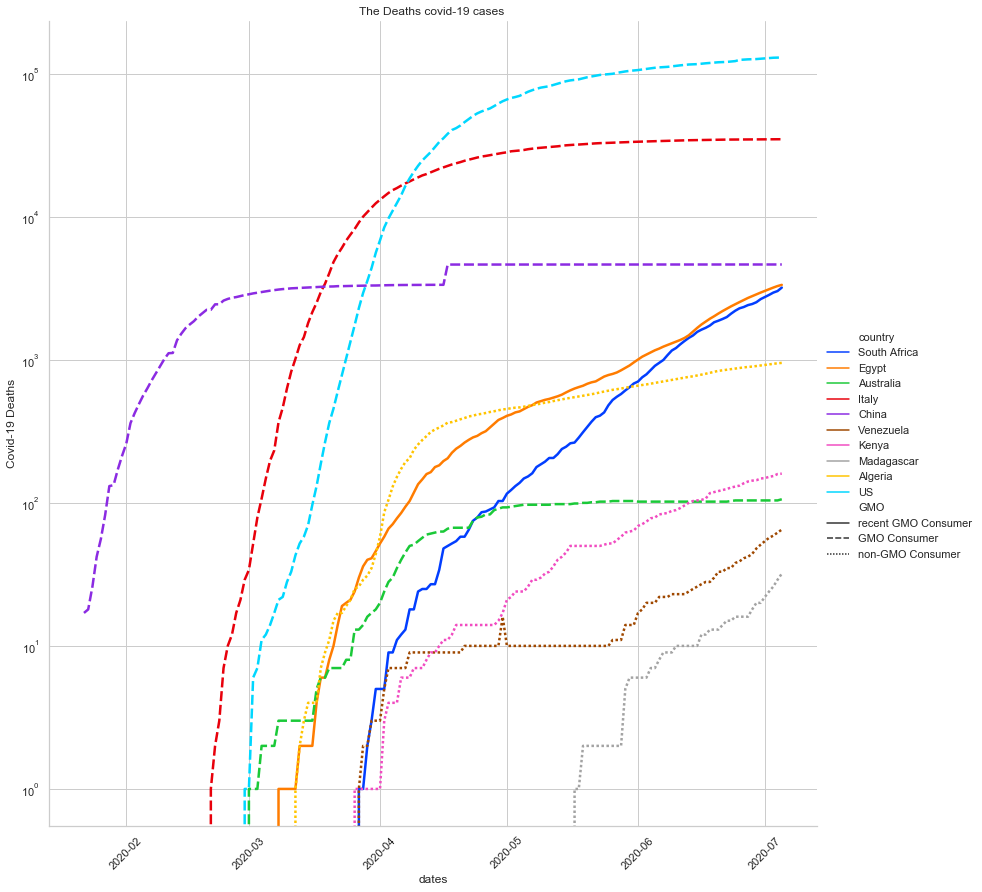

In [40]:
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='date',y='dead',data=dfd4,hue='country', kind='line', ci=None,  height= 12,sort=False,style='GMO',lw=2.5)
g.set(title = 'The Deaths covid-19 cases ',xlabel='dates',ylabel='Covid-19 Deaths')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

There might be a trend of sorts.

I could not find more GMO consumption data.

Changing deaths to rate of infected


In [41]:
dfd4['confirmed']= np.where(dfd4.date == dfc4.date, dfc4['confirmed'],0)

In [42]:
dfd4['rate']= dfd4['dead']/dfd4['confirmed']

In [43]:
dfd4

,date,country,dead,GMO,confirmed,rate
0,2020-01-22,South Africa,0,recent GMO Consumer,0,NaN
1,2020-01-22,Egypt,0,recent GMO Consumer,0,NaN
2,2020-01-22,Australia,0,GMO Consumer,0,NaN
3,2020-01-22,Italy,0,GMO Consumer,0,NaN
4,2020-01-22,China,17,GMO Consumer,548,0.031022
...,...,...,...,...,...,...
161,2020-07-01,US,128105,GMO Consumer,2687588,0.047665
162,2020-07-02,US,128803,GMO Consumer,2742049,0.046973
163,2020-07-03,US,129434,GMO Consumer,2794153,0.046323
164,2020-07-04,US,129676,GMO Consumer,2839436,0.045670


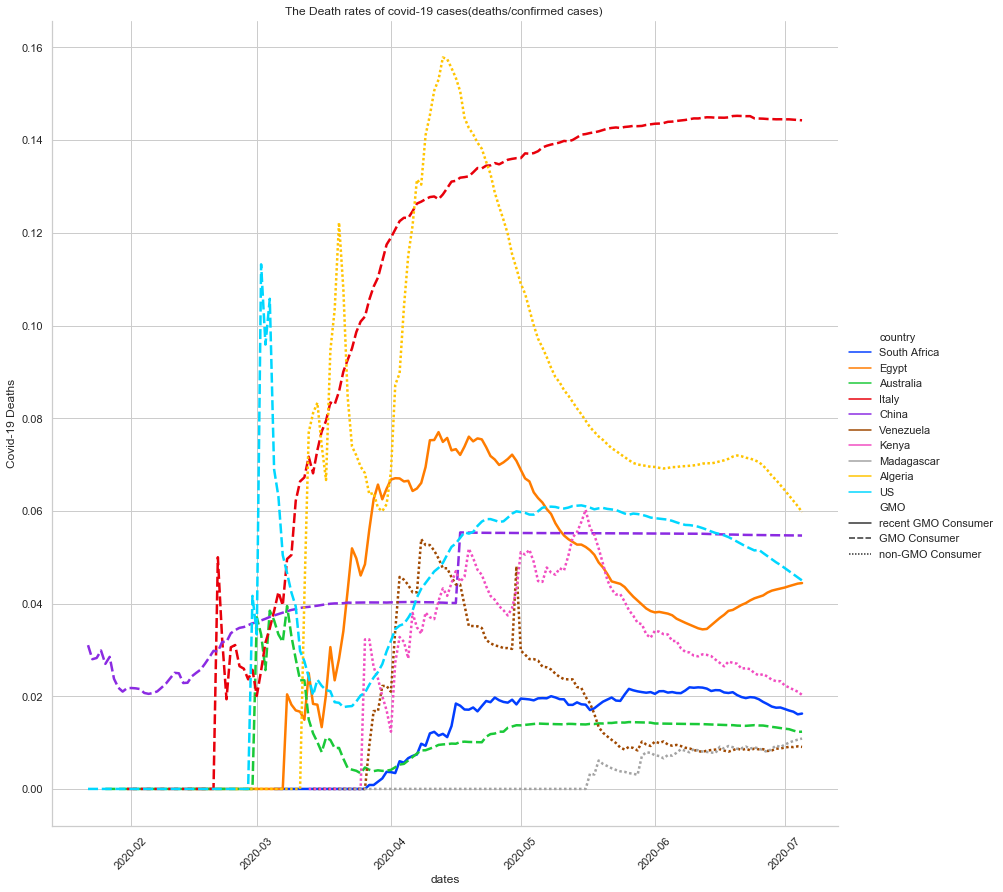

In [44]:
sns.set_style("whitegrid")
sns.set_palette('bright')
g = sns.relplot(x='date',y='rate',data=dfd4,hue='country', kind='line', ci=None,  height= 12,sort=False,style='GMO',lw=2.5)
g.set(title = 'The Death rates of covid-19 cases(deaths/confirmed cases) ',xlabel='dates',ylabel='Covid-19 Deaths')

sns.set_style("ticks", {"xtick.major": len(xticks)})
plt.xticks(rotation=45)
plt.show()

There is no trend